# Travelling Salesman Problem using Genetic Algorithm

### Importing Libraries

In [2]:
import matplotlib.pyplot as plt
from itertools import combinations
from random import shuffle
import random
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
def read_cities(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in range(6):
            next(file)

        for line in file:
            if line.strip() == "EOF":
                break

            parts = line.split()
            city_name = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            city = (city_name, (x, y))
            cities.append(city)

    return dict(cities)

In [4]:
points = read_cities('berlin52.tsp')

print(points)

{1: (565.0, 575.0), 2: (25.0, 185.0), 3: (345.0, 750.0), 4: (945.0, 685.0), 5: (845.0, 655.0), 6: (880.0, 660.0), 7: (25.0, 230.0), 8: (525.0, 1000.0), 9: (580.0, 1175.0), 10: (650.0, 1130.0), 11: (1605.0, 620.0), 12: (1220.0, 580.0), 13: (1465.0, 200.0), 14: (1530.0, 5.0), 15: (845.0, 680.0), 16: (725.0, 370.0), 17: (145.0, 665.0), 18: (415.0, 635.0), 19: (510.0, 875.0), 20: (560.0, 365.0), 21: (300.0, 465.0), 22: (520.0, 585.0), 23: (480.0, 415.0), 24: (835.0, 625.0), 25: (975.0, 580.0), 26: (1215.0, 245.0), 27: (1320.0, 315.0), 28: (1250.0, 400.0), 29: (660.0, 180.0), 30: (410.0, 250.0), 31: (420.0, 555.0), 32: (575.0, 665.0), 33: (1150.0, 1160.0), 34: (700.0, 580.0), 35: (685.0, 595.0), 36: (685.0, 610.0), 37: (770.0, 610.0), 38: (795.0, 645.0), 39: (720.0, 635.0), 40: (760.0, 650.0), 41: (475.0, 960.0), 42: (95.0, 260.0), 43: (875.0, 920.0), 44: (700.0, 500.0), 45: (555.0, 815.0), 46: (830.0, 485.0), 47: (1170.0, 65.0), 48: (830.0, 610.0), 49: (605.0, 625.0), 50: (595.0, 360.0), 5

## Visualising Cities

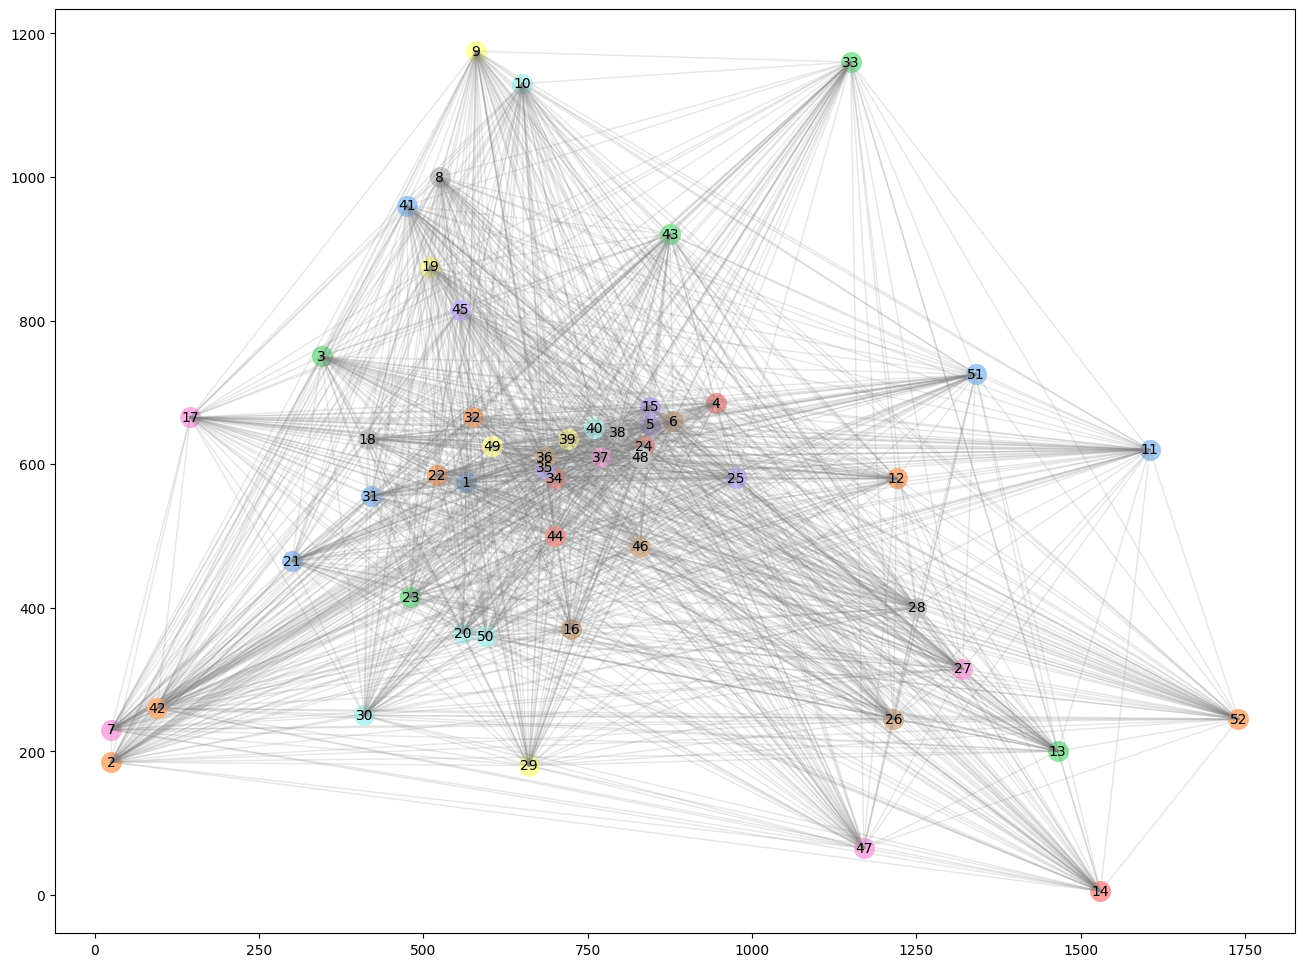

In [5]:
# Pastel Pallete
colors = sns.color_palette("pastel", len(points))

fig, ax = plt.subplots()

ax.grid(False)  # Grid

for i, (city, (city_x, city_y)) in enumerate(points.items()):
    color = colors[i]
    ax.scatter(city_x, city_y, c=[color], s=200, zorder=2)
    ax.annotate(city, (city_x, city_y), fontsize=10, ha='center', va='center', zorder=3)

    # Connect cities with opaque lines
    for j, (other_city, (other_x, other_y)) in enumerate(points.items()):
        if i != j:
            ax.plot([city_x, other_x], [city_y, other_y], color='gray', linestyle='-', linewidth=1, alpha=0.1)

fig.set_size_inches(16, 12)
plt.show()

## Population Function (Random Initialization)

In [6]:
import numpy as np
import random

def generate_permutations(lst, n):
    permutations = []
    for _ in range(n):
        temp_list = lst.copy()
        random.shuffle(temp_list)
        permutations.append(temp_list)
    return permutations

def initial_population(cities_list, n_population = 250):    
    return generate_permutations(list(cities_list.keys()), n_population)

def dist_two_cities(city_1, city_2):
    city_1_coords = points[city_1]
    city_2_coords = points[city_2]
    return np.sqrt(np.sum((np.array(city_1_coords) - np.array(city_2_coords))**2))

def total_dist_individual(individual):    
    total_dist = 0
    for i in range(0, len(individual)-1):
        total_dist += dist_two_cities(individual[i], individual[i+1])
    total_dist += dist_two_cities(individual[0], individual[-1])
    return total_dist

def fitness_prob(population):
    total_dist_all_individuals = []
    for i in range(0, len(population)):
        total_dist_all_individuals.append(total_dist_individual(population[i]))
        
    max_population_cost = max(total_dist_all_individuals)
    population_fitness = max_population_cost - total_dist_all_individuals
    population_fitness_sum = sum(population_fitness)
    population_fitness_probs = population_fitness / population_fitness_sum
    return population_fitness_probs

def roulette_wheel(population, fitness_probs):
    population_fitness_probs_cumsum = fitness_probs.cumsum()
    bool_prob_array = population_fitness_probs_cumsum < np.random.uniform(0,1,1)
    selected_individual_index = len(bool_prob_array[bool_prob_array == True]) - 1
    return population[selected_individual_index]

def crossover(parent_1, parent_2):
    n_cities_cut = len(points) - 1
    cut = round(random.uniform(1, n_cities_cut))
    offspring_1 = []
    offspring_2 = []
    
    offspring_1 = parent_1[0:cut]
    offspring_1 += [city for city in parent_2 if city not in offspring_1]
    
    
    offspring_2 = parent_2[0:cut]
    offspring_2 += [city for city in parent_1 if city not in offspring_2]
    
    
    return offspring_1, offspring_2

def mutation(offspring):
    n_cities_cut = len(points) - 1
    index_1 = round(random.uniform(0,n_cities_cut))
    index_2 = round(random.uniform(0,n_cities_cut))

    temp = offspring[index_1]
    offspring[index_1] = offspring[index_2]
    offspring[index_2] = temp
    return(offspring)

def run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per):
    population = initial_population(cities_names, n_population)
    
    for gen in range(n_generations):
        if gen % 10 == 0:
            print(f"Generation: {gen}")

        fitness_probs = fitness_prob(population)

        parents_list = [roulette_wheel(population, fitness_probs) for _ in range(int(crossover_per * n_population))]

        offspring_list = []
        for i in range(0, len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i + 1])
            offspring_1, offspring_2 = mutate_offspring(offspring_1, offspring_2, mutation_per)
            offspring_list.extend([offspring_1, offspring_2])

        population = select_new_population(offspring_list + parents_list, n_population)

    return population

def mutate_offspring(offspring_1, offspring_2, mutation_per):
    if random.random() > (1 - mutation_per):
        offspring_1 = mutation(offspring_1)
    if random.random() > (1 - mutation_per):
        offspring_2 = mutation(offspring_2)
    return offspring_1, offspring_2

def select_new_population(mixed_offspring, n_population):
    fitness_scores = fitness_prob(mixed_offspring)
    sorted_indices = np.argsort(fitness_scores)[::-1]
    best_offspring = [mixed_offspring[i] for i in sorted_indices[:int(0.8 * n_population)]]

    random_indices = np.random.choice(range(len(mixed_offspring)), size=int(0.2 * n_population), replace=False)
    random_offspring = [mixed_offspring[i] for i in random_indices]
    
    new_population = best_offspring + random_offspring
    random.shuffle(new_population)
    return new_population


In [7]:
n_population = 500
crossover_per = 0.9
mutation_per = 0.5
n_generations = 1000

best_mixed_offsrping = run_ga(points, n_population, n_generations, crossover_per, mutation_per)

Generation: 0
Generation: 10
Generation: 20
Generation: 30
Generation: 40
Generation: 50
Generation: 60
Generation: 70
Generation: 80
Generation: 90
Generation: 100
Generation: 110
Generation: 120
Generation: 130
Generation: 140
Generation: 150
Generation: 160
Generation: 170
Generation: 180
Generation: 190
Generation: 200
Generation: 210
Generation: 220
Generation: 230
Generation: 240
Generation: 250
Generation: 260
Generation: 270
Generation: 280
Generation: 290
Generation: 300
Generation: 310
Generation: 320
Generation: 330
Generation: 340
Generation: 350
Generation: 360
Generation: 370
Generation: 380
Generation: 390
Generation: 400
Generation: 410
Generation: 420
Generation: 430
Generation: 440
Generation: 450
Generation: 460
Generation: 470
Generation: 480
Generation: 490
Generation: 500
Generation: 510
Generation: 520
Generation: 530
Generation: 540
Generation: 550
Generation: 560
Generation: 570
Generation: 580
Generation: 590
Generation: 600
Generation: 610
Generation: 620
Gen

### Optimum Solution

In [8]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))

index_minimum = np.argmin(total_dist_all_individuals)

minimum_distance = min(total_dist_all_individuals)
print(minimum_distance)

# shortest_path = offspring_list[index_minimum]
shortest_path = best_mixed_offsrping[index_minimum]
print(shortest_path)

8878.328492554238
[16, 29, 47, 26, 27, 28, 12, 51, 43, 4, 6, 15, 5, 24, 48, 38, 37, 40, 39, 36, 1, 22, 31, 18, 3, 17, 21, 42, 7, 2, 30, 23, 20, 50, 44, 34, 35, 49, 32, 45, 19, 41, 8, 9, 10, 33, 11, 52, 14, 13, 25, 46]


### Optimum Solution Visualization

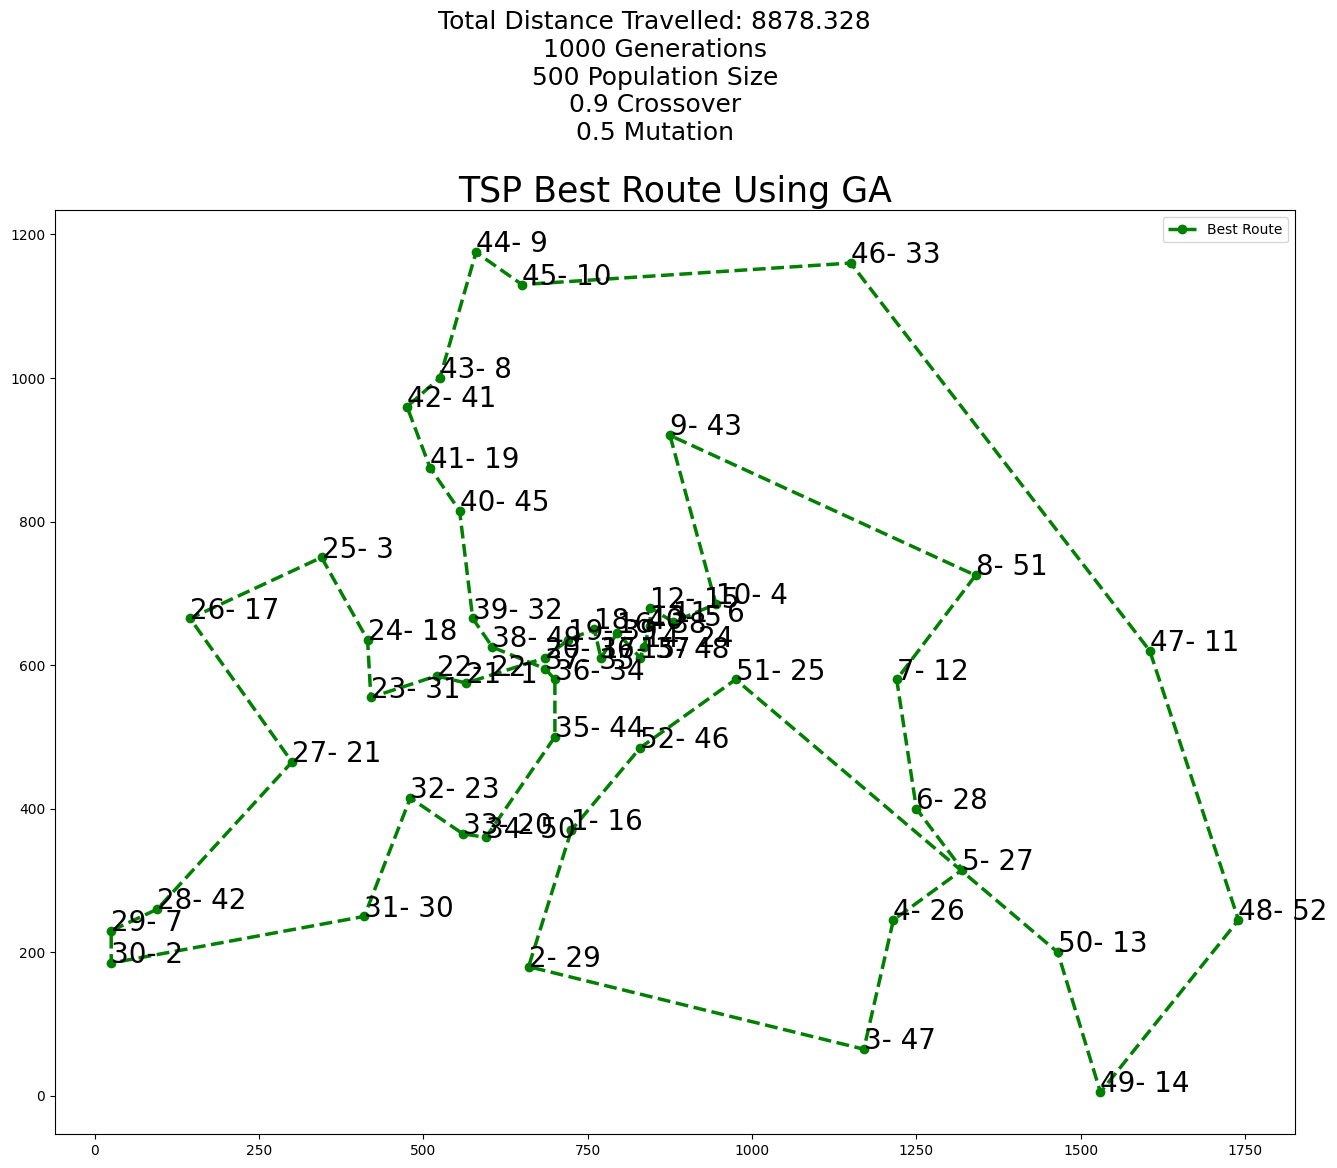

In [9]:
x_shortest = []
y_shortest = []
for city in shortest_path:
    x_value, y_value = points[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)
    
x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

x = list(map(lambda point: points[1][0], points))
y = list(map(lambda point: points[1][1], points))

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)
        
plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population Size\n'+str(crossover_per)+' Crossover\n'+str(mutation_per)+' Mutation'
plt.suptitle("Total Distance Travelled: "+ 
             str(round(minimum_distance, 3)) + 
             str_params, fontsize=18, y = 1.047)

for i, txt in enumerate(shortest_path):
    ax.annotate(str(i+1)+ "- " + str(txt), (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)    
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()